<a href="https://colab.research.google.com/github/michaelbarkasi/computational_neuroscience/blob/main/GLM_template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Template: Generalized Linear Models (GLM)

Michael Barkasi 2023

What is this? Sample code for doing GLMs, i.e. multi-dimensional linear regression.

Based on Neuromatch Academy 2023 W1D3 Tutorals

https://compneuro.neuromatch.io/tutorials/W1D3_GeneralizedLinearModels/chapter_title.html

[Creative Commons Attribution 4.0 International License](http://creativecommons.org/licenses/by/4.0/) //
[BSD (3-Clause) License](https://opensource.org/licenses/BSD-3-Clause)

In [26]:
# @title CoLab Reset
# Want to reset loaded code?
%reset -f

In [27]:
# @title Imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
#from scipy.io import loadmat

In [28]:
# @title Function for plotting results of cross validation
def plot_cross_validate_MSE(mse_all,lab):
  """ Plot the MSE values for the K_fold cross validation

  Args:
    mse_all (ndarray): an array of size (number of splits, number of hyperparameters)
  """
  plt.figure()
  plt.boxplot(mse_all, labels=lab)
  plt.xticks(rotation=90)
  plt.xlabel('Hyperparameter Value')
  plt.ylabel('Validation MSE')
  plt.title(f'Validation MSE over {mse_all.shape[0]} splits of the data')
  plt.show()

# Linear-Gaussian Regression Model w/ L1 and L2 Regularization

$y = XΘ + η$

* $y$ = data points (dependent variable)
* $X$ = design matrix (rows = data points, columns = features / independent variables)
* $Θ$ = parameters / linear filter
* $η$ = Gaussian noise (mean zero, variance $σ^2$)

NB: Features do not need to be independent.

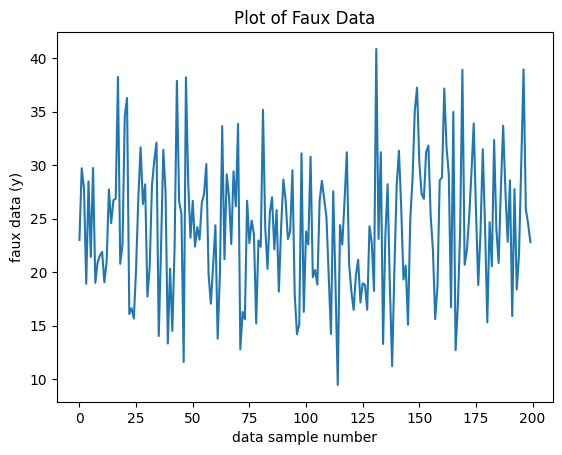

In [29]:
# @title Create faux data

# Set random seed
np.random.seed(0)

# Creat faux X data (integers) from uniform distribution
num_samples = 200
num_features = 10
X = np.random.randint(low=0,high=10,size=(num_samples,num_features))

# Create y with "ground truth" theta
theta_GT = np.random.uniform(0, 1, size = (num_features,))
y = X@theta_GT
# Add Gaussian noise w/ standard deviation 20% of mean
sigma = np.abs(np.mean(y) * 0.1)
y = np.array(y)+np.array(np.random.normal(0, sigma, size=len(y)))

# Plot y
plt.plot(np.arange(len(y)),y)
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.gca().xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
plt.xlabel('data sample number')
plt.ylabel('faux data (y)')
plt.title('Plot of Faux Data')
plt.show()

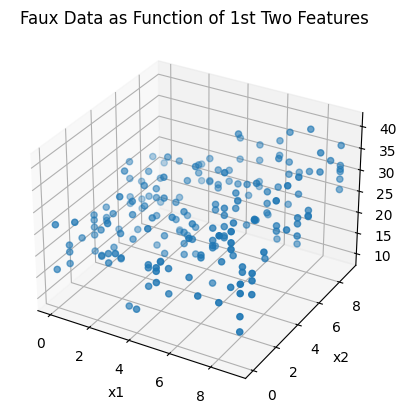

In [30]:
# @title Visualize faux data

# Plot faux data y as function of the first two dimensions of X
from mpl_toolkits import mplot3d

# Restrict X
X_res = X[:,0:2]
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(X_res[:,0], X_res[:,1], y)
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('y')
ax.set_title('Faux Data as Function of 1st Two Features')
plt.show()

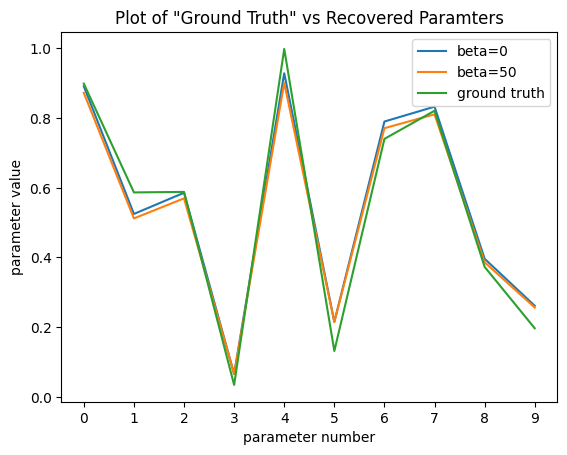

In [31]:
# @title Create GLM w/ L2 regularization

# Recover parameters
constant = np.ones_like(y)
X_plus = np.column_stack([constant, X])

# Try different L2 regularization parameters
beta1 = 0
beta2 = 50

# Get the MLE weights for the Linear-Gaussian model
# L2 Ridge regularization suppresses all weights
theta1_L2 = np.linalg.inv(X_plus.T @ X_plus + beta1 * np.eye(X_plus.shape[1])) @ X_plus.T @ y
theta2_L2 = np.linalg.inv(X_plus.T @ X_plus + beta2 * np.eye(X_plus.shape[1])) @ X_plus.T @ y

# Drop the bias / intercept for plotting
theta1_L2_ = theta1_L2[1:]
theta2_L2_ = theta2_L2[1:]

# Plot "Ground Truth" theta vs recovered theta
plt.plot(np.arange(len(theta1_L2_)),theta1_L2_,label=f"beta={beta1}")
plt.plot(np.arange(len(theta2_L2_)),theta2_L2_,label=f"beta={beta2}")
plt.plot(np.arange(len(theta_GT)),theta_GT,label="ground truth")
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.gca().xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
plt.xlabel('parameter number')
plt.ylabel('parameter value')
plt.title('Plot of "Ground Truth" vs Recovered Paramters')
plt.legend()
plt.show()

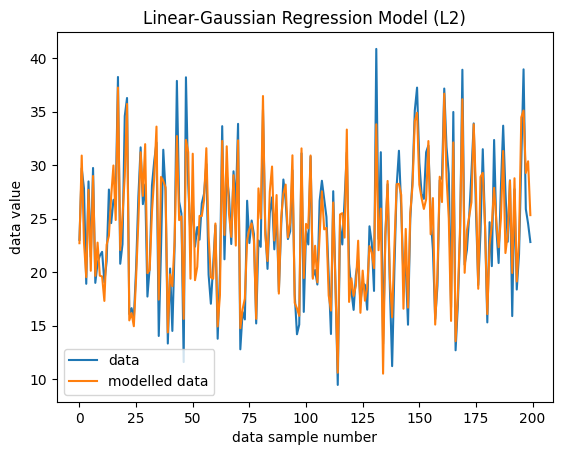

In [32]:
# @title Model data w/ GLM (L2 Regularization)

# Use recovered parameters to model the data
y_modelled = X_plus @ theta2_L2

# Print the real y vs modelled y
plt.plot(np.arange(len(y)),y,label="data")
plt.plot(np.arange(len(y_modelled)),y_modelled,label="modelled data")
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.gca().xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
plt.xlabel('data sample number')
plt.ylabel('data value')
plt.title('Linear-Gaussian Regression Model (L2)')
plt.legend()
plt.show()

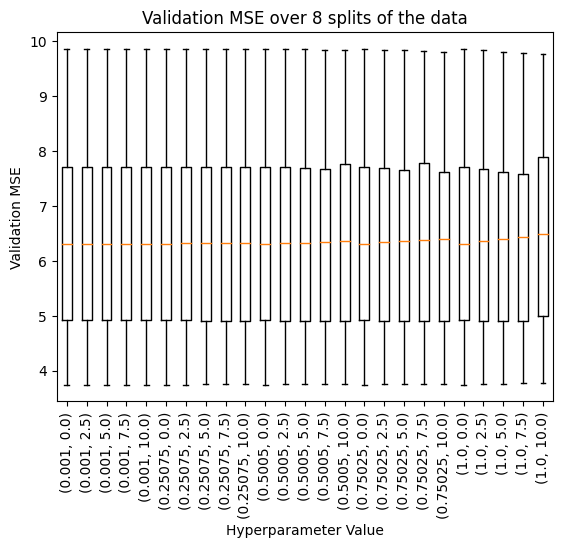

In [52]:
# @title Find best hyperparameters for L1 Regularization

# Cross Validation w/ L1 Regularization
# L1 encourages sparsity

from sklearn.model_selection import KFold
import itertools
from scipy.optimize import minimize

def neg_log_lik_gau_L1Reg(theta, X, y, sigma, beta):
  # Code from ChatGPT and checked against NMA slides, except regularization term line
  n = len(y)
  error = y - np.dot(X, theta)
  squared_error = np.dot(error.T, error)
  log_likelihood = -0.5 * n * np.log(2 * np.pi * sigma**2) - 0.5 * squared_error / (sigma**2)
  log_likelihood = log_likelihood + (beta/2)*np.sum(np.abs(theta)) # Regularization term
  return -log_likelihood

def fit_gau_L1Reg(data_y, data_X, sigma, beta):
  """Obtain MLE parameters for the Gaussian GLM.

  Returns:
    1D array: MLE parameters

  """

  constant = np.ones_like(data_y)
  data_X_plus = np.column_stack([constant, data_X])

  # Use a random vector of weights to start (mean 0, sd .2)
  x0 = np.random.normal(0, .2, data_X_plus.shape[1])

  # Find parameters that minmize the negative log likelihood function
  res = minimize(neg_log_lik_gau_L1Reg, x0, args=(data_X_plus, data_y, sigma, beta))

  return res["x"]

def cross_validate_LinGauss_L1(X_train, y_train, sigma_range, beta_range, n_splits):
  """ Compute MSE for k-fold validation for each order polynomial

  Args:
    x_train (ndarray): training data input vector of shape (n_samples,n_features)
    y_train (ndarray): training vector of measurements of shape (n_samples)
    n_split (scalar): number of folds for k-fold validation

  Return:
    ndarray: MSE over splits for model using theta, shape (n_splits,)

  """

  combined_range = list(itertools.product(sigma_range, beta_range))

  # Initialize the split method
  kfold_iterator = KFold(n_splits)

  # Initialize np array mse values for all models for each split
  mse_all = np.zeros((n_splits,len(combined_range)))

  for i_split, (train_indices, val_indices) in enumerate(kfold_iterator.split(X_train)):

    # Split up the overall training data into cross-validation training and validation sets
    X_cv_train = X_train[train_indices]
    y_cv_train = y_train[train_indices]
    X_cv_val = X_train[val_indices]
    y_cv_val = y_train[val_indices]

    for i_hypers, (sigma,beta) in enumerate(combined_range):

      theta = fit_gau_L1Reg(y_cv_train,X_cv_train,sigma,beta)
      constant = np.ones_like(y_cv_val)
      X_cv_val_plus = np.column_stack([constant, X_cv_val])
      y_modelled = X_cv_val_plus @ theta

      residuals = y_cv_val - y_modelled
      mse_all[i_split,i_hypers] = np.mean(residuals**2)

  return mse_all

betas = np.linspace(0, 10, 5)
sigmas = np.linspace(0.001, 1, 5)
hypers = list(itertools.product(sigmas, betas))
mse = cross_validate_LinGauss_L1(X,y,sigmas,betas,8)

plot_cross_validate_MSE(mse,hypers)

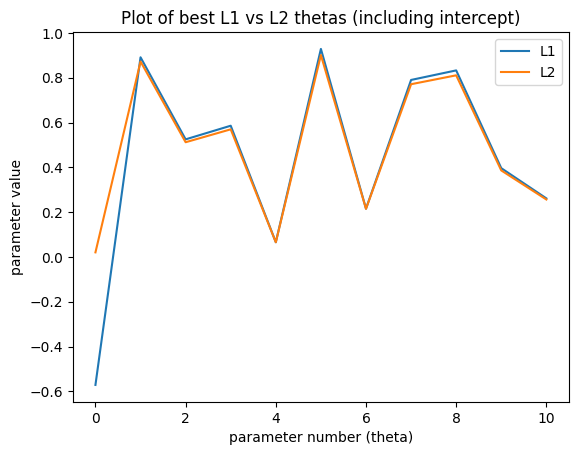

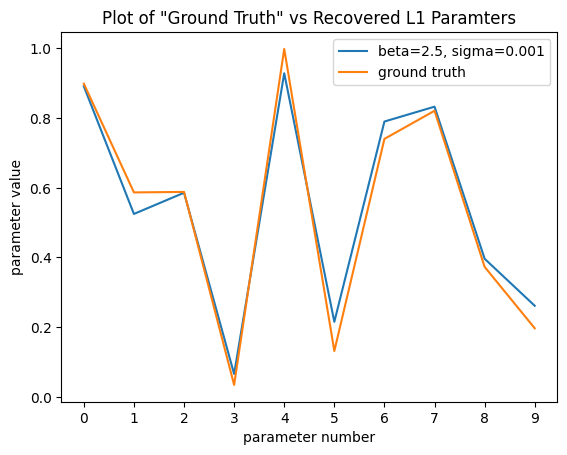

In [58]:
# @title Create GLM with best hyperparameters for L1 regularizations

# From above, we see that there isn't really a "best" hyperparameter combination, so we just pick one.
sigma = 0.001
beta = 2.5

# Get weights for the Linear-Gaussian model
# L1 encourages sparsity
theta_L1 = fit_gau_L1Reg(y,X,sigma,beta)

# Plot/compare these new L1 thetas with best L2 thetas, including intercept
plt.plot(np.arange(len(theta_L1)),theta_L1,label=f"L1")
plt.plot(np.arange(len(theta2_L2)),theta2_L2,label="L2")
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.gca().xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
plt.xlabel('parameter number (theta)')
plt.ylabel('parameter value')
plt.title('Plot of best L1 vs L2 thetas (including intercept)')
plt.legend()
plt.show()

# Drop the bias / intercept for plotting
theta_L1_ = theta_L1[1:]

# Plot "Ground Truth" theta vs recovered theta
plt.plot(np.arange(len(theta_L1_)),theta_L1_,label=f"beta={beta}, sigma={sigma}")
plt.plot(np.arange(len(theta_GT)),theta_GT,label="ground truth")
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.gca().xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
plt.xlabel('parameter number')
plt.ylabel('parameter value')
plt.title('Plot of "Ground Truth" vs Recovered L1 Paramters')
plt.legend()
plt.show()

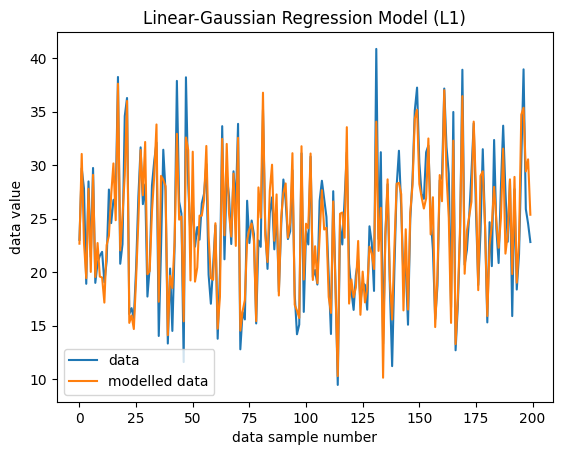

In [59]:
# @title Model data w/ GLM (L1 Regularization)

# Use recovered parameters to model the data
y_modelled_L1 = X_plus @ theta_L1

# Print the real y vs modelled y
plt.plot(np.arange(len(y)),y,label="data")
plt.plot(np.arange(len(y_modelled_L1)),y_modelled_L1,label="modelled data")
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.gca().xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
plt.xlabel('data sample number')
plt.ylabel('data value')
plt.title('Linear-Gaussian Regression Model (L1)')
plt.legend()
plt.show()

# Linear-Poisson Regression Model w/ L2 Regularization

$y = e^{XΘ} + P$

* $y$ = data points (dependent variable)
* $X$ = design matrix (rows = data points, columns = features / independent variables)
* $Θ$ = parameters / linear filter
* $P$ = Poisson noise (mean rate y)

NB: Features do not need to be independent.

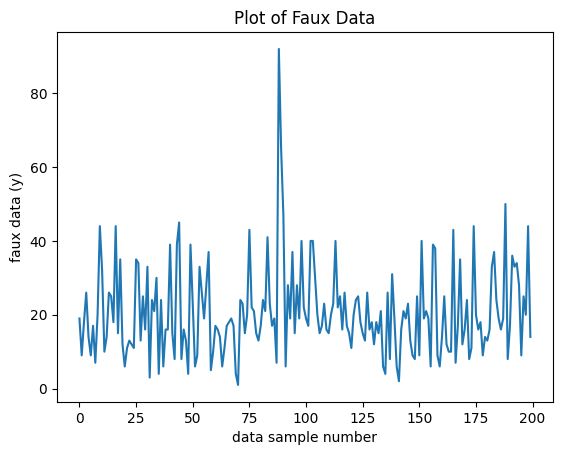

In [60]:
# @title Create faux data

# Set random seed
np.random.seed(3)

# Creat faux data (integers) from uniform distribution
num_samples = 200
num_features = 10
X = np.random.uniform(low=0,high=1,size=(num_samples,num_features)) # low = 0 to ensure no negative values

# Create y with "ground truth" theta
theta_GT = np.random.uniform(0, 1, size = (num_features,))
y = np.round(np.exp(X@theta_GT))
# Add Poisson noise
y = np.random.poisson(lam=y)

# Print "ground truth" theta
# print(f"'Ground Truth' theta: {theta_GT}")

# Plot y
plt.plot(np.arange(len(y)),y)
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.gca().xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
plt.xlabel('data sample number')
plt.ylabel('faux data (y)')
plt.title('Plot of Faux Data')
plt.show()

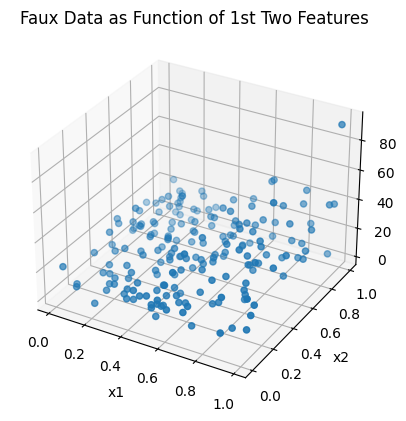

In [61]:
# @title Visualize faux data

# Plot faux data y as function of the first two dimensions of X
from mpl_toolkits import mplot3d

# Restrict X
X_res = X[:,0:2]
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(X_res[:,0], X_res[:,1], y)
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('y')
ax.set_title('Faux Data as Function of 1st Two Features')
plt.show()

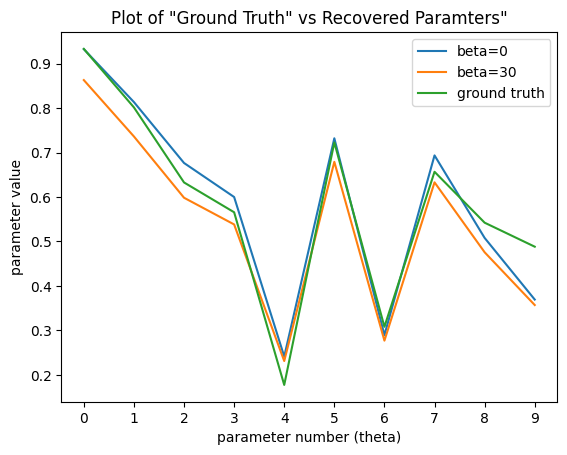

In [63]:
# @title Create LNP model w/ L2 regularization

from scipy.optimize import minimize

# Functions

def neg_log_lik_lnp_L2Reg(theta, X, y, beta):
  """Return -loglike for the Poisson GLM model.

  Args:
    theta (1D array): Parameter vector.
    X (2D array): Full design matrix.
    y (1D array): Data values.

  Returns:
    number: Negative log likelihood.

  """

  # Compute the Poisson log likelihood
  rate = np.exp(X @ theta)
  log_lik = y @ np.log(rate) - rate.sum()
  output = -log_lik + (beta/2)*np.sum(np.square(theta))

  return output

def fit_lnp_L2Reg(data_y, data_X, beta):
  """Obtain MLE parameters for the Poisson GLM.

  Args:
    stim (1D array): Stimulus values at each timepoint
    spikes (1D array): Spike counts measured at each timepoint
    d (number): Number of time lags to use.

  Returns:
    1D array: MLE parameters

  """

  constant = np.ones_like(data_y)
  data_X_plus = np.column_stack([constant, data_X])

  # Use a random vector of weights to start (mean 0, sd .2)
  x0 = np.random.normal(0, .2, data_X_plus.shape[1])

  # Find parameters that minmize the negative log likelihood function
  res = minimize(neg_log_lik_lnp_L2Reg, x0, args=(data_X_plus, data_y, beta))

  return res["x"]

# Fit LNP model / Recover parameters
# L2 regularization suppresses all features (e.g., notice how higher beta > lower thetas)
theta_lnp1 = fit_lnp_L2Reg(y, X, 0)
theta_lnp2 = fit_lnp_L2Reg(y, X, 30)

# Drop the bias / intercept for plotting
theta_lnp1_ = theta_lnp1[1:]
theta_lnp2_ = theta_lnp2[1:]

# Plot "Ground Truth" theta vs recovered theta
plt.plot(np.arange(len(theta_lnp1_)),theta_lnp1_,label="beta=0")
plt.plot(np.arange(len(theta_lnp2_)),theta_lnp2_,label="beta=30")
plt.plot(np.arange(len(theta_GT)),theta_GT,label="ground truth")
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.gca().xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
plt.xlabel('parameter number (theta)')
plt.ylabel('parameter value')
plt.title('Plot of "Ground Truth" vs Recovered Paramters"')
plt.legend()
plt.show()

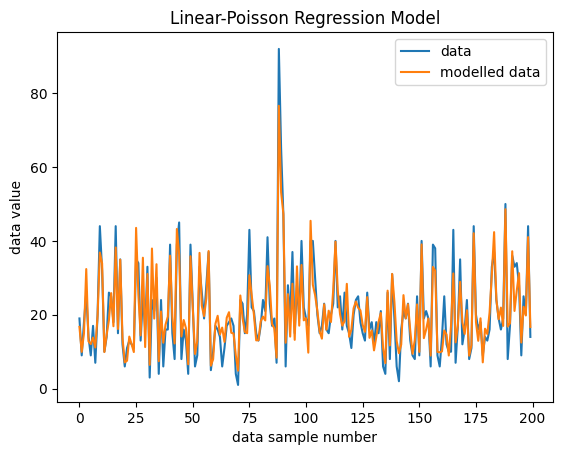

In [64]:
# @title Model data w/ LNP  (L2 regularization)

def LinPoisRegModel(X_data,theta_est):
  n = X_data.shape[0]
  constant = np.ones((n, 1))
  X_plus = np.column_stack([constant,X_data])
  y_modelled = np.exp(X_plus @ theta_est)
  return y_modelled

# Use recovered parameters to model the data
y_modelled = LinPoisRegModel(X,theta_lnp2)

# Print the real y vs modelled y
plt.plot(np.arange(len(y)),y,label="data")
plt.plot(np.arange(len(y_modelled)),y_modelled,label="modelled data")
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.gca().xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
plt.xlabel('data sample number')
plt.ylabel('data value')
plt.title('Linear-Poisson Regression Model')
plt.legend()
plt.show()

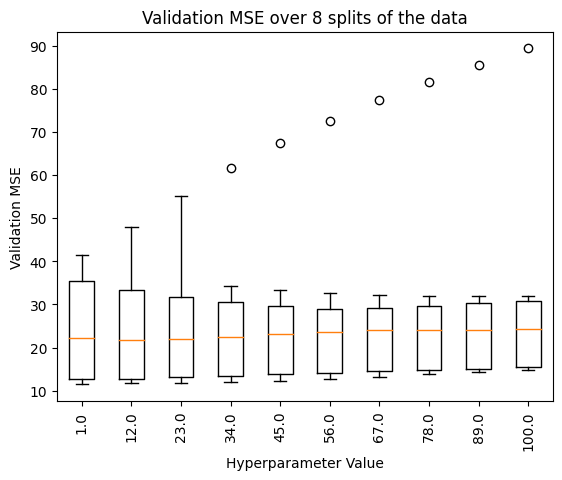

In [67]:
# @title Cross validation w/ L2 regularization (Final best beta)

# NB: We see the best is around beta=30, which is what we used in the plot above.

from sklearn.model_selection import KFold

def cross_validate_LinPois_L2(X_train, y_train, beta_range, n_splits):
  """ Compute MSE for k-fold validation for each order polynomial

  Args:
    x_train (ndarray): training data input vector of shape (n_samples,n_features)
    y_train (ndarray): training vector of measurements of shape (n_samples)
    n_split (scalar): number of folds for k-fold validation

  Return:
    ndarray: MSE over splits for model using theta, shape (n_splits,)

  """

  # Initialize the split method
  kfold_iterator = KFold(n_splits)

  # Initialize np array mse values for all models for each split
  mse_all = np.zeros((n_splits,len(beta_range)))

  for i_split, (train_indices, val_indices) in enumerate(kfold_iterator.split(X_train)):

    # Split up the overall training data into cross-validation training and validation sets
    X_cv_train = X_train[train_indices]
    y_cv_train = y_train[train_indices]
    X_cv_val = X_train[val_indices]
    y_cv_val = y_train[val_indices]

    for i_beta, beta in enumerate(beta_range):

      theta = fit_lnp_L2Reg(y_cv_train,X_cv_train,beta) # e.g., theta_func =
      y_modelled = LinPoisRegModel(X_cv_val,theta) # e.g., model_func = LinPoisRegModel

      residuals = y_cv_val - y_modelled
      mse_all[i_split,i_beta] = np.mean(residuals**2)

  return mse_all

betas = np.linspace(1, 100, 10)
mse = cross_validate_LinPois_L2(X,y,betas,8)

plot_cross_validate_MSE(mse,betas)